LAB 

Classifying Names with a Character-Level RNN
======================
**prepared by**: Eliya Masesa, (Team Leader) ParrotAi.


INTRODUCTION:
-------------
**What is Natural Language Processing?**
----------------------------------------
NLP is a way for computers to analyze, understand, and derive meaning from human language in a smart and useful way. By utilizing NLP, developers can organize and structure knowledge to perform tasks such as:
* automatic summarization, 
* translation, 
* named entity recognition, 
* relationship extraction, 
* sentiment analysis, 
* speech recognition 
* topic segmentation.

**What is RNN?**
---------------
This is a neural net that processes sequential data, and takes in as input both the new input at the current timestep and the output (or a hidden layer) of the net in the previous timestep. The most popular type of RNN is probably the LSTM, which has a ‘cell state’ at each time step that changes with new input.

**Why use RNN in NLP?**<br/>
----------------------
RNN (Recurrent Neural Network) is primarily used in NLP. For instance, an application of RNN is in language modelling or text generation. These kind of tasks demands you to understand the semantics and syntactic form of the sentences. In other words, the dependency between the words, say, what “Y” word should appear to the next of some “X” word, should be taken into account.

Thus, RNN have this capability (you can learn the dependency by BPTT i.e., Back propagation through time) which a conventional neural network lacks. RNN seems to perform better in those NLP tasks and that is why you basically use RNN.


TASK:
----
We will be building and training a basic character-level RNN to classify
words. A character-level RNN reads words as a series of characters -
outputting a prediction and "hidden state" at each step, feeding its
previous hidden state into each next step. We take the final prediction
to be the output, i.e. which class the word belongs to.

### **Learning Objectives**

Specifically, we'll train on a few thousand surnames from 18 languages
of origin predict which language a name is from based on the
spelling:

In [20]:
#importing modules that we will work with
from __future__ import unicode_literals, print_function, division
from io import open
import glob

def findFiles(path): 
    return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

['data/names\\Arabic.txt', 'data/names\\Chinese.txt', 'data/names\\Czech.txt', 'data/names\\Dutch.txt', 'data/names\\English.txt', 'data/names\\French.txt', 'data/names\\German.txt', 'data/names\\Greek.txt', 'data/names\\Irish.txt', 'data/names\\Italian.txt', 'data/names\\Japanese.txt', 'data/names\\Korean.txt', 'data/names\\Polish.txt', 'data/names\\Portuguese.txt', 'data/names\\Russian.txt', 'data/names\\Scottish.txt', 'data/names\\Spanish.txt', 'data/names\\Vietnamese.txt']


In [21]:
#takes all letters both uppercase and lower case and concatenates with those special characters into one list
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)
print (all_letters)

abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'


In [3]:
#Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))


Slusarski


In [4]:
# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []


In [5]:
# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = filename.split('/')[-1].split('\\')[-1].split('.')[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories) # number of categories

In [6]:
print (all_categories)

['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French', 'German', 'Greek', 'Irish', 'Italian', 'Japanese', 'Korean', 'Polish', 'Portuguese', 'Russian', 'Scottish', 'Spanish', 'Vietnamese']


Now we have category_lines, a dictionary mapping each category (language) to a list of lines (names). We also kept track of all_categories (just a list of languages) and n_categories for later reference.

In [7]:
print(category_lines['Russian'][:10])

['Ababko', 'Abaev', 'Abagyan', 'Abaidulin', 'Abaidullin', 'Abaimoff', 'Abaimov', 'Abakeliya', 'Abakovsky', 'Abakshin']


Turning Names into Tensors
--------------------------

Now that we have all the names organized, we need to turn them into
Tensors to make any use of them.

To represent a single letter, we use a "one-hot vector" of size
``<1 x n_letters>``. A one-hot vector is filled with 0s except for a 1
at index of the current letter, e.g. ``"b" = <0 1 0 0 0 ...>``.

To make a word we join a bunch of those into a 2D matrix
``<line_length x 1 x n_letters>``.

That extra 1 dimension is because PyTorch assumes everything is in
batches - we're just using a batch size of 1 here.

In [8]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])
torch.Size([5, 1, 57])


Creating the Network
====================

Before autograd, creating a recurrent neural network in Torch involved
cloning the parameters of a layer over several timesteps. The layers
held hidden state and gradients which are now entirely handled by the
graph itself. This means you can implement a RNN in a very "pure" way,
as regular feed-forward layers.

In [9]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

To run a step of this network we need to pass an input (in our case, the
Tensor for the current letter) and a previous hidden state (which we
initialize as zeros at first). We'll get back the output (probability of
each language) and a next hidden state (which we keep for the next
step).

In [10]:
input = letterToTensor('A')
hidden =torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)
print(output)
print(output.size())

tensor([[-2.9175, -2.8912, -2.8427, -2.8704, -2.8188, -2.9128, -2.8329,
         -3.0009, -2.9091, -2.8778, -2.8312, -2.9274, -2.9189, -2.8201,
         -2.9000, -2.8946, -2.9202, -2.9611]])
torch.Size([1, 18])


For the sake of efficiency we don't want to be creating a new Tensor for
every step, so we will use ``lineToTensor`` instead of
``letterToTensor`` and use slices. This could be further optimized by
pre-computing batches of Tensors.

In [11]:
input = lineToTensor('Ablent')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.9175, -2.8912, -2.8427, -2.8704, -2.8188, -2.9128, -2.8329,
         -3.0009, -2.9091, -2.8778, -2.8312, -2.9274, -2.9189, -2.8201,
         -2.9000, -2.8946, -2.9202, -2.9611]])


Generally: The output is a ``<1 x n_categories>`` Tensor, where
every item is the likelihood of that category (higher is more likely).

Training
========
Preparing for Training
----------------------

Before going into training we should make a few helper functions. The
first is to interpret the output of the network, which we know to be a
likelihood of each category. We can use ``Tensor.topk`` to get the index
of the greatest value:

> More formally, let:<br/>
>> *predictions <sub>i</sub>* be the predictions for all classes for example i, <br/>
>> *targets<sub>i</sub>*-be the target class for example i, <br/>
>> *out<sub>i</sub>*-be the output for example i,<br/>
>> *out<sub>i</sub> = predictions <sub>i</sub>, targets<sub>i</sub> ∈  TopKIncludingTies (predictions <sub>i</sub>)*

[ top K predictions](https://www.tensorflow.org/api_docs/python/tf/nn/in_top_k)

In [12]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('English', 4)


We will also want a quick way to get a training example (a name and its
language):

In [13]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Italian / line = Accorsi
category = Chinese / line = Hua
category = Arabic / line = Safar
category = Portuguese / line = Freitas
category = English / line = Jowett
category = German / line = Baumbach
category = Japanese / line = Iseki
category = Dutch / line = Haenraats
category = Chinese / line = Hor
category = English / line = Kram


Training the Network
--------------------

Now all it takes to train this network is show it a bunch of examples,
have it make guesses, and tell it if it's wrong.

For the loss function ``nn.NLLLoss`` is appropriate, since the last
layer of the RNN is ``nn.LogSoftmax``.

In [14]:
criterion = nn.NLLLoss()

Observation
-----------
Each loop of training will:

-  Create input and target tensors
-  Create a zeroed initial hidden state
-  Read each letter in and

   -  Keep hidden state for next letter

-  Compare final output to target
-  Back-propagate
-  Return the output and loss



In [15]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

Now we just have to run that with a bunch of examples. Since the
``train`` function returns both the output and loss we can print its
guesses and also keep track of loss for plotting. Since there are 1000s
of examples we print only every ``print_every`` examples, and take an
average of the loss.


In [16]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 5s) 2.7151 Le / Chinese ✗ (Vietnamese)
10000 10% (0m 10s) 2.9985 Stroman / Scottish ✗ (German)
15000 15% (0m 15s) 2.8254 Karlovsky / Polish ✗ (Czech)
20000 20% (0m 20s) 0.6069 Gorski / Polish ✓
25000 25% (0m 25s) 0.2421 Rutkowski / Polish ✓
30000 30% (0m 31s) 0.2713 Wronski / Polish ✓
35000 35% (0m 36s) 2.6518 Bonhomme / Russian ✗ (French)
40000 40% (0m 42s) 0.9586 Cao / Chinese ✗ (Vietnamese)
45000 45% (0m 47s) 0.7181 Cornett / French ✓
50000 50% (0m 52s) 1.7034 Vennen / German ✗ (Dutch)
55000 55% (0m 58s) 3.4177 Persein / Irish ✗ (Czech)
60000 60% (1m 3s) 3.4436 Lynn / Korean ✗ (English)
65000 65% (1m 9s) 1.2751 Jiggens / English ✓
70000 70% (1m 14s) 1.0781 Zielinski / Polish ✓
75000 75% (1m 19s) 3.0883 Schlantz / German ✗ (Czech)
80000 80% (1m 25s) 1.7212 Orellana / Italian ✗ (Spanish)
85000 85% (1m 30s) 1.4902 Grogan / Irish ✗ (English)
90000 90% (1m 36s) 3.5895 MonkoAustria / Greek ✗ (Czech)
95000 95% (1m 41s) 1.9190 Duarte / French ✗ (Portuguese)
100000 100% (1m 47s) 

Plotting the Results
--------------------

Plotting the historical loss from ``all_losses`` shows the network
learning:



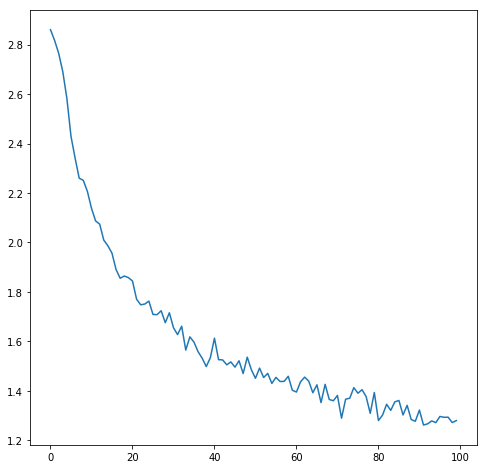

In [23]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20, 11
%matplotlib inline

plt.figure(figsize=(8,8))
plt.plot(all_losses)

Evaluating the Results
======================

To see how well the network performs on different categories, we will
create a confusion matrix, indicating for every actual language (rows)
which language the network guesses (columns). To calculate the confusion
matrix a bunch of samples are run through the network with
``evaluate()``, which is the same as ``train()`` minus the backprop.


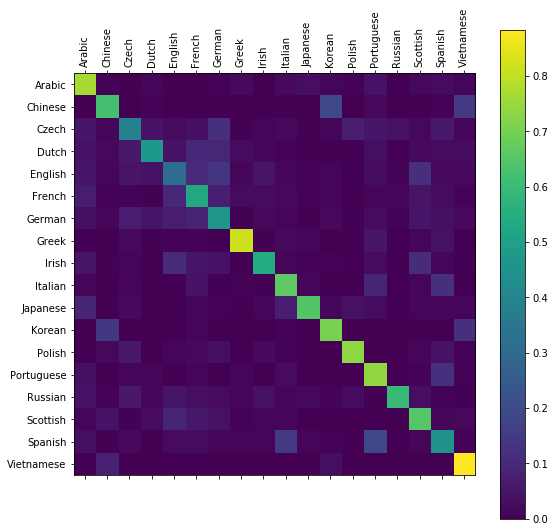

In [24]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

You can pick out bright spots off the main axis that show which
languages it guesses incorrectly, e.g. Chinese for Korean, and Spanish
for Italian. It seems to do very well with Greek, and very poorly with
English (perhaps because of overlap with other languages).

Running on User Input
---------------------

In [19]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Arafat')
predict('Janet')
predict('Satoshi')


> Arafat
(-0.51) Arabic
(-2.25) French
(-2.75) Czech

> Janet
(-1.45) Korean
(-1.77) French
(-2.12) German

> Satoshi
(-0.98) Arabic
(-1.49) Japanese
(-2.00) Portuguese


References
----------
* http://chandlerzuo.github.io/blog/2017/11/darnn
* https://brilliant.org/wiki/recurrent-neural-network/
* https://www.cpuheater.com/deep-learning/introduction-to-recurrent-neural-networks-in-pytorch/
* https://pytorch.org/tutorials/beginner/nlp/deep_learning_tutorial.html#sphx-glr-beginner-nlp-deep-learning-tutorial-py

SELF PRACTICE:
--------------
-  Get better results with a bigger and/or better shaped network

   -  Add more linear layers
   -  Try the ``nn.LSTM`` and ``nn.GRU`` layers
   -  Combine multiple of these RNNs as a higher level network
